<a href="https://colab.research.google.com/github/mohamedhanfi/Car-Type-Classification/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import pandas as pd


In [2]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
for layer in base_model.layers:
    layer.trainable=False

In [4]:
# Install the Kaggle package if not already installed
!pip install kaggle

# Download the dataset
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

# Unzip the dataset
!unzip stanford-car-dataset-by-classes-folder.zip -d car_data

Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
 99% 1.81G/1.83G [00:09<00:00, 249MB/s]
100% 1.83G/1.83G [00:09<00:00, 215MB/s]
unzip:  cannot find or open stanford-car-dataset-by-classes-folder.zip -d car_data, stanford-car-dataset-by-classes-folder.zip -d car_data.zip or stanford-car-dataset-by-classes-folder.zip -d car_data.ZIP.


In [5]:
!unzip stanford-car-dataset-by-classes-folder.zip -d car_data

Streaming output truncated to the last 5000 lines.
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/04381.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/04688.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/04772.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/05544.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/05728.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/05860.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06146.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06157.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06332.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06441.jpg  
  inflating: car_data/car_data/car_data/train/Chrysler Aspen SUV 2009/06447.jpg  
  inflating: car_data/car_data/car_data/train/C

In [6]:
# Define the paths
train_dir = '/content/car_data/car_data/car_data/train'
val_dir = '/content/car_data/car_data/car_data/test'


# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    rescale=1./255
)

val_datagen = ImageDataGenerator(
    rescale=1./255
    )





In [7]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# Create data generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

# Load pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(196, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=outputs)


Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [8]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [9]:
# Train the model
history = model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping, checkpoint, reduce_lr])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.0316 - loss: 18.7137 - val_accuracy: 0.2110 - val_loss: 16.3939 - learning_rate: 1.0000e-04
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.2452 - loss: 14.4525 - val_accuracy: 0.5570 - val_loss: 11.9804 - learning_rate: 1.0000e-04
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.5696 - loss: 11.1563 - val_accuracy: 0.7114 - val_loss: 9.4460 - learning_rate: 1.0000e-04
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.7524 - loss: 8.9144 - val_accuracy: 0.7635 - val_loss: 7.8439 - learning_rate: 1.0000e-04
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.8535 - loss: 7.2158 - val_accuracy: 0.7995 - val_loss: 6.5150 - learning_rate: 1.0000e-04
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy: 0.9056 - loss: 5.8841 - val_accuracy: 0.8140 - val_loss: 5.4548 - learning_rate: 1.0000e-04
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - accuracy:

In [10]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

252/252 ━━━━━━━━━━━━━━━━━━━━ 71s 280ms/step - accuracy: 0.8387 - loss: 2.7032
Validation Loss: 2.711820363998413
Validation Accuracy: 0.8353438377380371


In [12]:
# Get predictions on validation data
val_data.reset()  # Reset the generator for evaluation
predictions = model.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)

252/252 ━━━━━━━━━━━━━━━━━━━━ 60s 229ms/step


In [15]:

# Get true labels from the validation data generator
true_classes = val_data.classes  # This gives the true labels

# Generate classification report
class_labels = list(val_data.class_indices.keys())  # Get class labels
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Convert metrics to percentage
report_df['precision'] = report_df['precision'] * 100
report_df['recall'] = report_df['recall'] * 100
report_df['f1-score'] = report_df['f1-score'] * 100
report_df['support'] = report_df['support'].astype(int)  # Make support an integer value

# Display the classification report
print(report_df[['precision', 'recall', 'f1-score', 'support']])

                               precision    recall  f1-score  support
AM General Hummer SUV 2000      2.000000  2.272727  2.127660       44
Acura Integra Type R 2001       0.000000  0.000000  0.000000       44
Acura RL Sedan 2012             0.000000  0.000000  0.000000       32
Acura TL Sedan 2012             0.000000  0.000000  0.000000       43
Acura TL Type-S 2008            0.000000  0.000000  0.000000       42
...                                  ...       ...       ...      ...
Volvo XC90 SUV 2007             2.564103  2.325581  2.439024       43
smart fortwo Convertible 2012   0.000000  0.000000  0.000000       40
accuracy                        0.683995  0.683995  0.683995        0
macro avg                       0.725585  0.666804  0.675580     8041
weighted avg                    0.743296  0.683995  0.692483     8041

[199 rows x 4 columns]


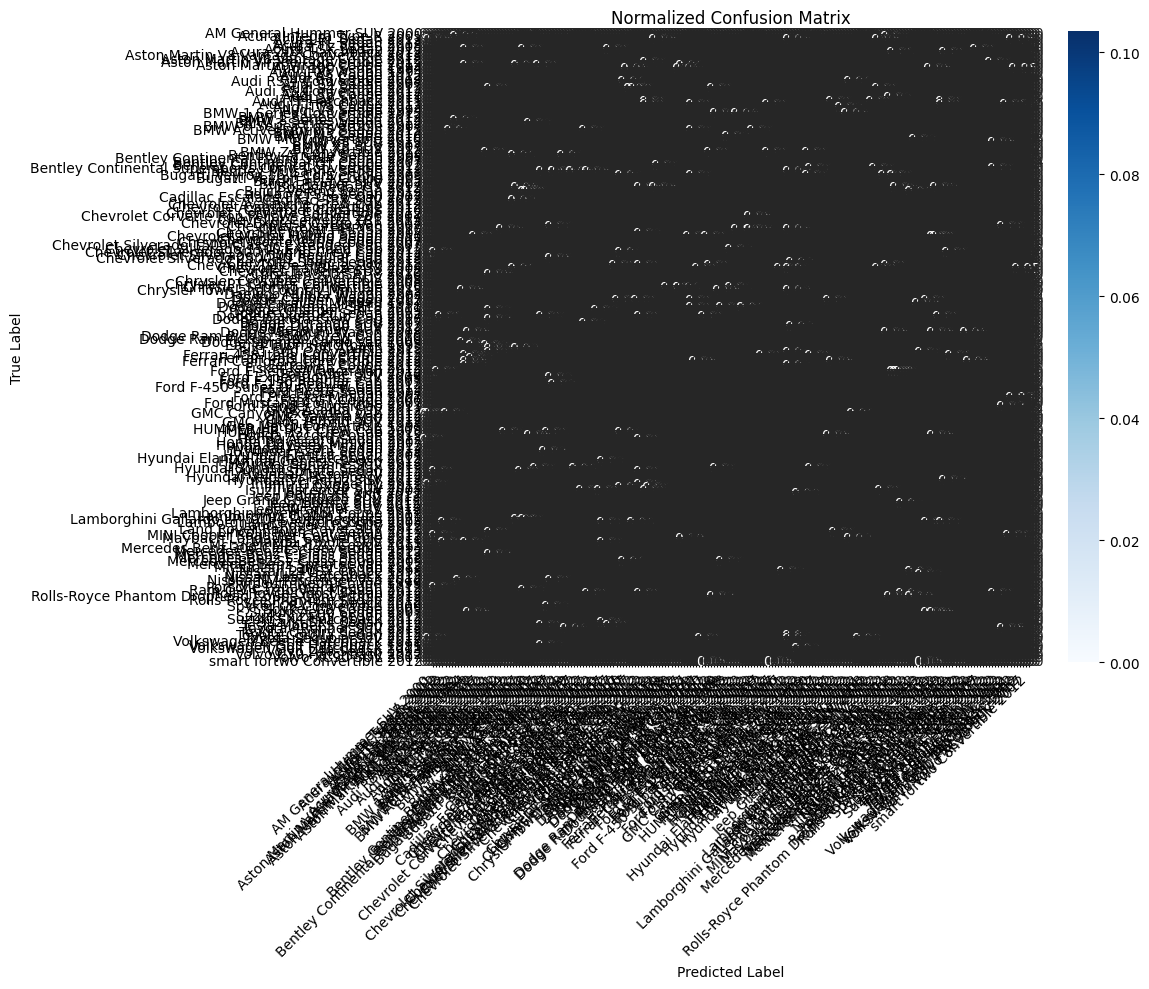

In [16]:
# Compute confusion matrix and normalize it
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotting Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

252/252 ━━━━━━━━━━━━━━━━━━━━ 55s 217ms/step


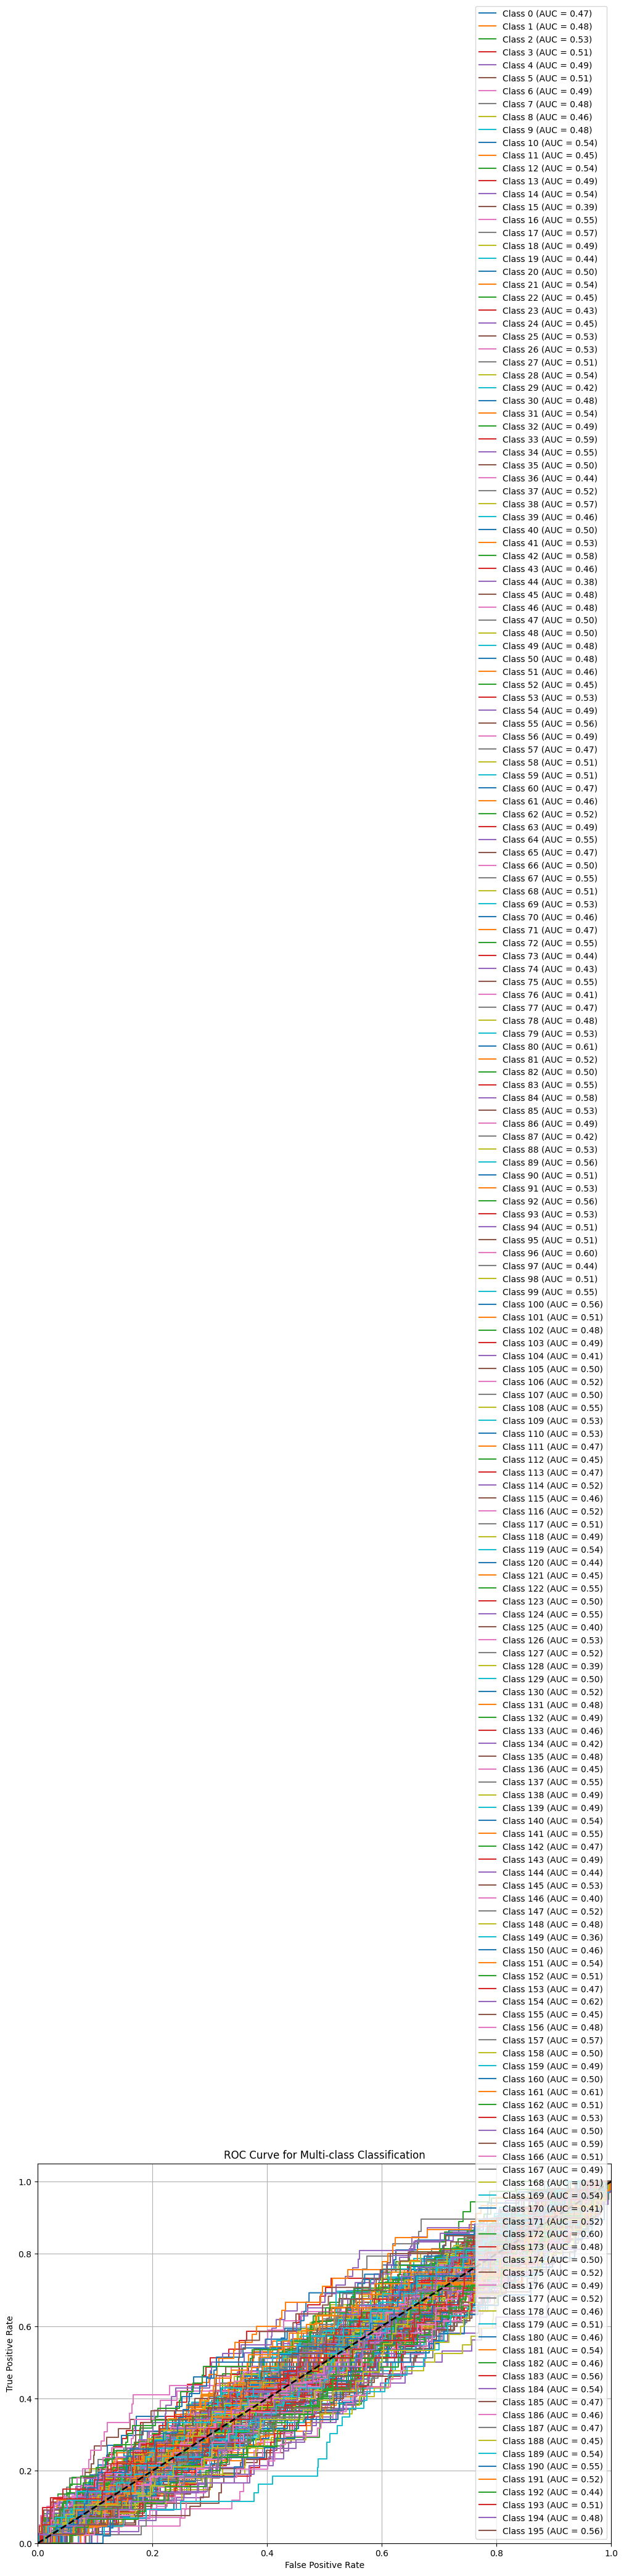

In [17]:
# Get true labels from the validation data generator
true_classes = val_data.classes  # This gives the true labels

# Binarize the output labels for multi-class ROC
n_classes = len(val_data.class_indices)  # Number of classes
true_classes_binarized = label_binarize(true_classes, classes=range(n_classes))



# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()

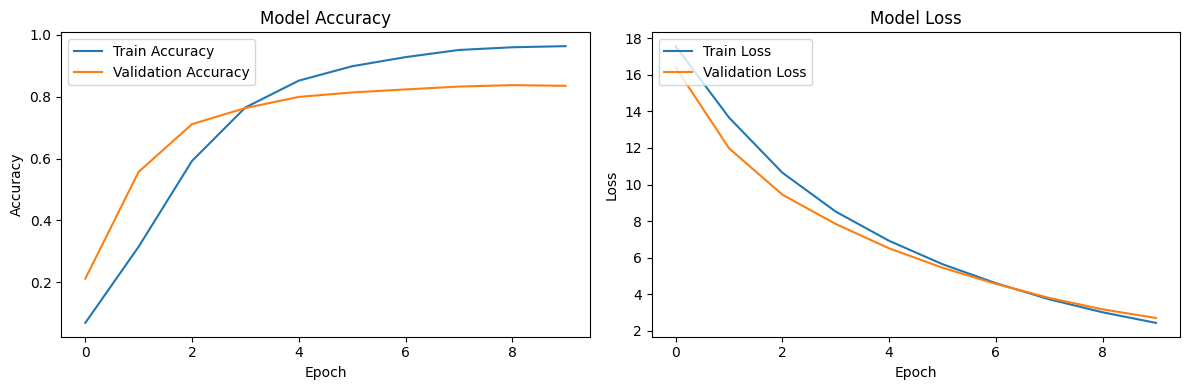

In [18]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [1]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_model.keras')


In [2]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def prediction(image_path, model, class_indices, target_size=(299, 299)):

    # Preprocess the image
    def preprocess_image(image_path, target_size=(299, 299)):
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        return np.expand_dims(img_array, axis=0)

    # Preprocess the input image
    preprocessed_image = preprocess_image(image_path, target_size)

    # Make prediction
    predictions = model.predict(preprocessed_image)
    predicted_label = np.argmax(predictions, axis=1)[0]

    # Map the predicted label to the class name
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[predicted_label]

    # Display the image with the prediction
    img = load_img(image_path, target_size=target_size)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


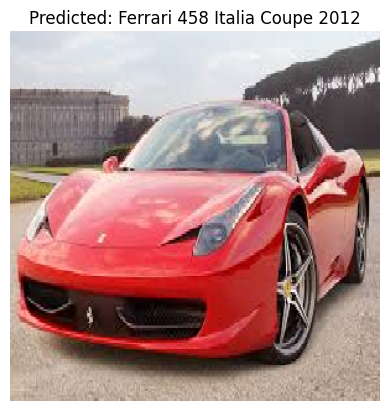

The predicted class is: Ferrari 458 Italia Coupe 2012


In [27]:
# Call the function
image_path = "images.jpeg"  # Replace with your image path
predicted_class = prediction(image_path, model, train_data.class_indices)

print(f"The predicted class is: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


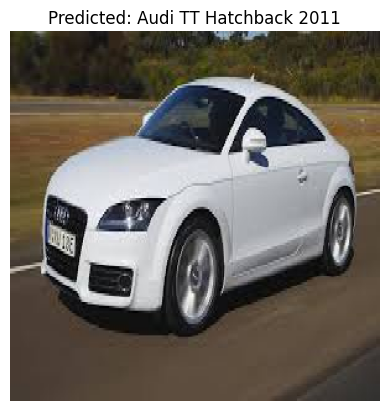

The predicted class is: Audi TT Hatchback 2011


In [28]:
# Call the function
image_path = "image2.jpeg"  # Replace with your image path
predicted_class = prediction(image_path, model, train_data.class_indices)

print(f"The predicted class is: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


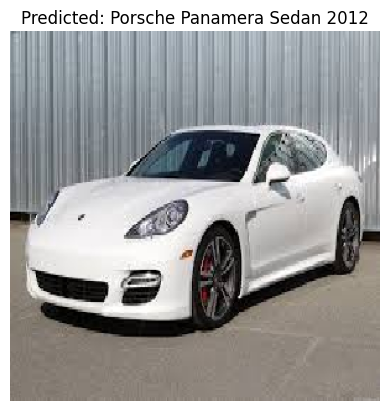

The predicted class is: Porsche Panamera Sedan 2012


In [30]:
# Call the function
image_path = "image3.jpeg"  # Replace with your image path
predicted_class = prediction(image_path, model, train_data.class_indices)

print(f"The predicted class is: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


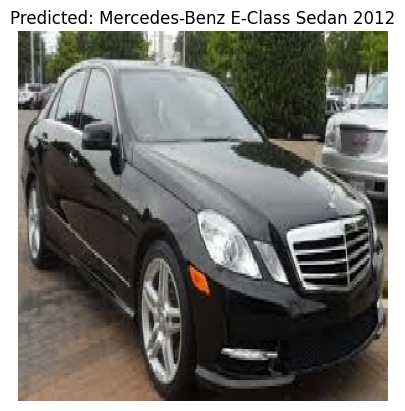

The predicted class is: Mercedes-Benz E-Class Sedan 2012


In [31]:
# Call the function
image_path = "image4.jpeg"  # Replace with your image path
predicted_class = prediction(image_path, model, train_data.class_indices)

print(f"The predicted class is: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


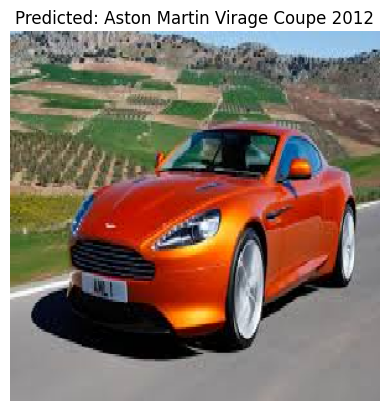

The predicted class is: Aston Martin Virage Coupe 2012


In [33]:
# Call the function
image_path = "image5.jpeg"  # Replace with your image path
predicted_class = prediction(image_path, model, train_data.class_indices)

print(f"The predicted class is: {predicted_class}")
